In [2]:
using LinearAlgebra
using FFTW
using Statistics
using JLD2
using NPZ
using ProgressMeter
using BenchmarkTools
using Plots

In [3]:

function next_fast_len(target::Int)::Int
    """
    Find the next fast size of input data to `fft`, for zero-padding, etc.

    Returns the next composite of the prime factors 2, 3, and 5 which is
    greater than or equal to `target`. (These are also known as 5-smooth
    numbers, regular numbers, or Hamming numbers.)

    Parameters
    ----------
    target : Int
        Length to start searching from. Must be a positive integer.

    Returns
    -------
    out : Int
        The first 5-smooth number greater than or equal to `target`.
    """
    # Precomputed Hamming numbers (5-smooth numbers) for quick lookup
    hams = [
        8, 9, 10, 12, 15, 16, 18, 20, 24, 25, 27, 30, 32, 36, 40, 45, 48, 50,
        54, 60, 64, 72, 75, 80, 81, 90, 96, 100, 108, 120, 125, 128, 135, 144,
        150, 160, 162, 180, 192, 200, 216, 225, 240, 243, 250, 256, 270, 288,
        300, 320, 324, 360, 375, 384, 400, 405, 432, 450, 480, 486, 500, 512,
        540, 576, 600, 625, 640, 648, 675, 720, 729, 750, 768, 800, 810, 864,
        900, 960, 972, 1000, 1024, 1080, 1125, 1152, 1200, 1215, 1250, 1280,
        1296, 1350, 1440, 1458, 1500, 1536, 1600, 1620, 1728, 1800, 1875, 1920,
        1944, 2000, 2025, 2048, 2160, 2187, 2250, 2304, 2400, 2430, 2500, 2560,
        2592, 2700, 2880, 2916, 3000, 3072, 3125, 3200, 3240, 3375, 3456, 3600,
        3645, 3750, 3840, 3888, 4000, 4050, 4096, 4320, 4374, 4500, 4608, 4800,
        4860, 5000, 5120, 5184, 5400, 5625, 5760, 5832, 6000, 6075, 6144, 6250,
        6400, 6480, 6561, 6750, 6912, 7200, 7290, 7500, 7680, 7776, 8000, 8100,
        8192, 8640, 8748, 9000, 9216, 9375, 9600, 9720, 10000
    ]

    if target <= 6
        return target
    end

    # Check if target is already a power of 2
    if (target & (target - 1)) == 0
        return target
    end

    # Quick lookup for small sizes
    if target <= hams[end]
        idx = searchsortedfirst(hams, target)
        return hams[idx]
    end

    # Function to compute the bit length of an integer
    bit_length(x::Int) = x <= 0 ? 0 : floor(Int, log2(x)) + 1

    match = typemax(Int)  # Initialize with maximum possible integer
    p5 = 1
    while p5 < target
        p35 = p5
        while p35 < target
            # Ceiling integer division
            quotient = cld(target, p35)
            p2 = 2^bit_length(quotient - 1)
            N = p2 * p35
            if N == target
                return N
            elseif N < match
                match = N
            end
            p35 *= 3
            if p35 == target
                return p35
            end
        end
        if p35 < match
            match = p35
        end
        p5 *= 5
        if p5 == target
            return p5
        end
    end
    if p5 < match
        match = p5
    end
    return match
end

### Tapers
function _extend(M::Int, sym::Bool)::Tuple{Int,Bool}
    # Extend window by 1 sample if needed for DFT-even symmetry
    if !sym
        return M + 1, true
    else
        return M, false
    end
end


function _fftautocorr(x::AbstractMatrix{<:Float64})::Array{Float64, 2}
    """
    tested vs python:
    isapprox(x_fft, py_x_fft, atol=1e-12) == true
    isapprox(py_cxy, cxy, atol=1e-12) == true
    """
    N = size(x, 2)
    use_N = next_fast_len(2 * N - 1)
    padded = zeros(Float64, size(x, 1), use_N)
    padded[:, 1:N] .= x
    plan = plan_rfft(padded, 2)
    x_fft = plan * padded
    cxy = irfft(x_fft .* conj.(x_fft), use_N, 2)[:, 1:N]
    return cxy
end

function py_dpss(M::Int, NW::Float64, normalization_type::Int, Kmax::Int; sym::Bool=true)::Tuple{Array{Complex{Float64},2},Union{Array{Float64,1},Float64}}
    """
    Compute the Discrete Prolate Spheroidal Sequences (DPSS).

    Parameters
    ----------
    M : Int
        Window length.
    NW : Float64
        Standardized half bandwidth corresponding to 2*NW = BW/f0 = BW*M*dt
        where dt is taken as 1.
    normalization_type : Int
        Normalization of the DPSS windows. Must be one of 1, 2, or 3.
        1: No normalization.
        2: Approximate normalization.
        3: Subsample normalization.
    Kmax : Int
        Number of DPSS windows to return. Must be less than or equal to M and greater than 0.
        If 1, return only a single window of shape (M,)
        instead of an array of windows of shape (Kmax, M).
    sym : Bool, optional
        When true (default), generates a symmetric window, for use in filter design.
        When false, generates a periodic window, for use in spectral analysis.

    return_ratios : Bool, optional
        If true, also return the concentration ratios in addition to the windows.

    Returns
    -------
    windows : Array{Float64, 2} or Array{Float64, 1}
        The DPSS windows. Will be 1D if `Kmax` is nothing.
    ratios : Array{Float64, 1} or Float64, optional
        The concentration ratios for the windows. Only returned if
        `return_ratios` evaluates to true. Will be scalar if `Kmax` is nothing.
    """
    known_norms = (1, 2, 3)
    if normalization_type ∉ known_norms
        error("normalization_type must be one of $known_norms, got $normalization_type")
    end
    if Kmax === 1
        singleton = true
    else
        singleton = false
    end
    if !(0 < Kmax <= M)
        error("Kmax must be greater than 0 and less than or equal to M")
    end
    if NW >= M / 2.0
        error("NW must be less than M/2.")
    end
    if NW <= 0
        error("NW must be positive")
    end

    M, needs_trunc = _extend(M, sym)
    W = NW / M
    nidx = collect(0:M-1)
    d = ((M - 1 .- 2 .* nidx) ./ 2.0) .^ 2 .* cos.(2pi * W)
    e = nidx[2:end] .* (M .- nidx[2:end]) ./ 2.0
    # Use SymTridiagonal for efficient eigenvalue computation
    T = SymTridiagonal(d, e)
    evals = eigvals(T, M-Kmax+1:M);
    evecs = eigvecs(T, evals);

    # Extract the largest Kmax eigenvalues and eigenvectors
    indices = M-Kmax+1:M

    # windows = eigs.vectors[end:-1:1, indices]
    windows = evecs[:, end:-1:1]'
    # Correct sign conventions
    fix_even = sum(windows[1:2:end, :], dims=2) .< 0
    windows[1:2:end, :][fix_even[:, 1], :] .*= -1

    # # Correct signs for even-indexed windows
    thresh = max(1e-7, 1.0 / M)
    for (i, w) in enumerate(eachrow(windows[2:2:end, :]))
        idx = findfirst(x -> x^2 > thresh, w)
        if idx !== nothing && w[idx] < 0
            windows[2i, :] *= -1
        end
    end

    # Compute concentration ratios
    dpss_rxx = _fftautocorr(windows)
    r = 4 * W * sinc.(2 * W .* (nidx))
    r[1] = 2 * W
    ratios = dpss_rxx * r

    if singleton
        ratios = ratios[1]
    end
    # Apply normalization if needed
    if normalization_type != 1
        max_abs = maximum(abs, windows)
        windows ./= max_abs
        if iseven(M)
            if normalization_type == 2
                correction = M^2 / (M^2 + NW)
            elseif normalization_type == 3
                s = rfft(windows[1, :])
                shift = -(1 - 1.0 / M) .* (1:Int(M / 2))
                s[2:end] .*= 2 .* exp.(-im * π .* shift)
                correction = M / sum(real(s))
            end
            windows .*= correction
        end
    end

    if needs_trunc
        windows = windows[:, 1:end-1]
    end
    if singleton
        windows = windows[1, :]
    end
    return windows, ratios
end

py_dpss (generic function with 1 method)

In [4]:
julia_output_path = "/media/dan/Data/git/network_mining/connectivity/julia_test"
python_output_path = "/media/dan/Data/git/network_mining/julia_v_python_connectivity/non_simulated_data/python_outputs/"

"/media/dan/Data/git/network_mining/julia_v_python_connectivity/non_simulated_data/python_outputs/"

# ossilations same?

In [5]:
n_taps = 3
n_cycles = 7
mt_bandwidth = 4.0
sfreq = 2048
freqs = collect(14:1023)
N = 1024
zero_mean = true

n_freqs = length(freqs)
weights = Array{Float64,3}(undef, n_taps, n_freqs, N)
Ws = Matrix{Vector{ComplexF64}}(undef, n_taps, n_freqs)
sp5 = sqrt(0.5)
# Loop over frequencies first
Threads.@threads for k in eachindex(freqs)
    f = freqs[k]
    t_win = n_cycles / f
    len_t = Int(ceil(t_win * sfreq))

    t = collect(0:1/sfreq:t_win-(t_win % (1 / sfreq) == 0 ? 1 / sfreq : 0)) # exclude last value if it fits exactly
    t_centered = t .- t_win / 2.0

    # Precompute oscillation and taper
    oscillation = exp.(2.0 * im * pi * f .* t_centered)
    for m = 1:n_taps
        py_oss = npzread(joinpath(python_output_path, "oscillation~epoch0_tap$(m-1)_freq$(f).npy"))
        @assert isapprox(oscillation, py_oss, atol=1e-12) "diff at freq $f tap $(m-1)"
    end

end


In [6]:
n_taps = 3
n_cycles = 7
mt_bandwidth = 4.0
sfreq = 2048
freqs = collect(14:1023)
N = 1024
zero_mean = true

# Loop over frequencies first
for k in eachindex(freqs)
    f = freqs[k]
    t_win = n_cycles / f
    len_t = Int(ceil(t_win * sfreq))
    # @show len_t
    taper, e = py_dpss(len_t, mt_bandwidth / 2, 1, n_taps, sym=false)
    # @show size(taper)
    for m = 1:n_taps
        py_taper = npzread(joinpath(python_output_path, "dpss~epoch0_tap$(m-1)_freq$(f).npy"))
        # @show size(py_taper)
        @assert isapprox(taper, py_taper, atol=1e-11) "diff at freq $f tap $(m)"
    end
end


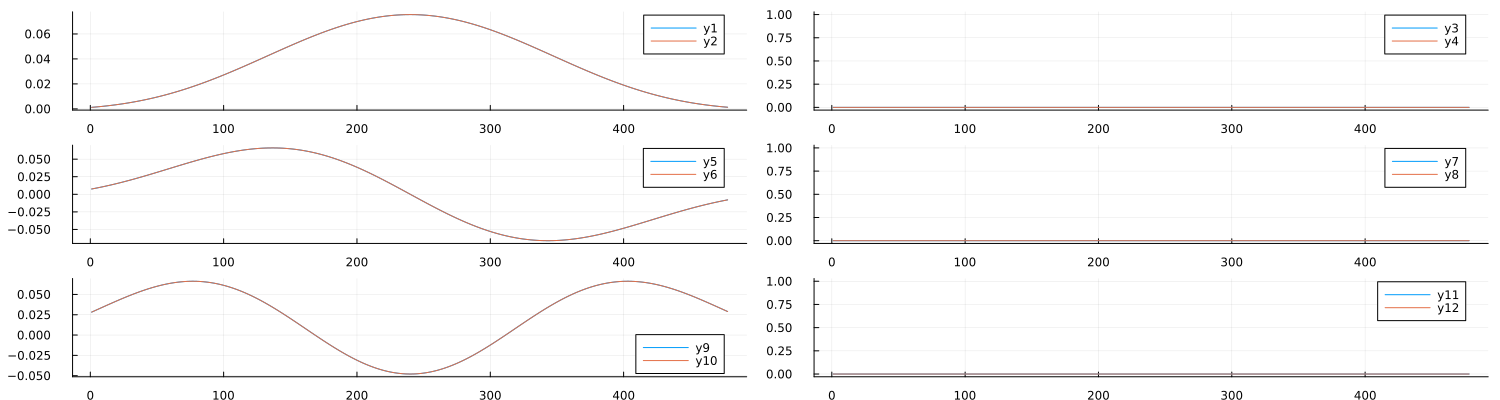

In [7]:
taper, e = py_dpss(478, mt_bandwidth / 2, 1, n_taps, sym=false)
m = 1
f = 30
py_taper = npzread(joinpath(python_output_path, "dpss~epoch0_tap$(m-1)_freq$(f).npy"));
p = plot(layout=(3, 2), size=(1500, 400))  # Define a combined layout
for i in 1:3
    plot!(p,real(taper[i, :]), layout=(3, 2),subplot=1+(i-1)*2)
    plot!(p,real(py_taper[i, :]),subplot=1+(i-1)*2)
    plot!(p,imag(taper[i, :]),subplot=2+(i-1)*2)
    plot!(p,imag(py_taper[i, :]),subplot=2+(i-1)*2)
end
display(p)

In [8]:
OUTPUT_PATH = "/media/dan/Data/git/network_mining/julia_v_python_connectivity/org_python_dbg_outputs/tapers"


freqs = collect(14:2000)
n_taps = 3
n_cycles = 7
mt_bandwidth = 4.0
sfreq = 2048


# Loop over frequencies first
for k in eachindex(freqs)
    f = freqs[k]
    t_win = n_cycles / f
    len_t = Int(ceil(t_win * sfreq))
    # @show len_t
    taper, e = py_dpss(len_t, mt_bandwidth / 2, 1, n_taps, sym=false)
    py_taper = npzread(joinpath(OUTPUT_PATH, "windows6~M-$(len_t)_NW-2_K-3_sym-False_norm-2.npy"))
    # @show size(py_taper)
    @assert isapprox(taper, py_taper, atol=1e-11) "diff at freq $f"
end


Can we remove the inversions?

In [9]:
len_t = 478

M = 478
NW = mt_bandwidth / 2
normalization_type = 1
Kmax = 3
sym = false

M, needs_trunc = _extend(M, sym)
W = NW / M
nidx = collect(0:M-1)
d = ((M - 1 .- 2 .* nidx) ./ 2.0) .^ 2 .* cos.(2pi * W)
py_d = npzread(joinpath(OUTPUT_PATH, "d~M-$(len_t)_NW-2_K-3_sym-False_norm-2.npy"))
@assert isapprox(d, py_d, atol=1e-15) "diff at d"

e = nidx[2:end] .* (M .- nidx[2:end]) ./ 2.0;
py_e = npzread(joinpath(OUTPUT_PATH, "e~M-$(len_t)_NW-2_K-3_sym-False_norm-2.npy"))
@assert isapprox(e, py_e, atol=1e-15) "diff at e"

# Use SymTridiagonal for efficient eigenvalue computation
T = SymTridiagonal(d, e)
# eigs = eigen(T)

# only calculate the eigenvalues and eigenvectors we need
evals = eigvals(T, M-Kmax+1:M);
evecs = eigvecs(T, evals);

py_eigs = npzread(joinpath(OUTPUT_PATH, "w1~M-$(len_t)_NW-2_K-3_sym-False_norm-2.npy"))
@assert isapprox(evals, py_eigs, atol=1e-11) "diff at eigs"

py_windows = npzread(joinpath(OUTPUT_PATH, "windows1~M-$(len_t)_NW-2_K-3_sym-False_norm-2.npy"))
@assert isapprox(evecs, py_windows, atol=1e-13) "diff at windows1"

# windows = eigs.vectors[end:-1:1, indices]
evecs = evecs[:, end:-1:1]'

py_windows2 = npzread(joinpath(OUTPUT_PATH, "windows2~M-$(len_t)_NW-2_K-3_sym-False_norm-2.npy"))
@assert isapprox(evecs, py_windows2, atol=1e-13) "diff at windows2"

# # Correct sign conventions
fix_even = sum(windows[1:2:end, :], dims=2) .< 0
windows[1:2:end, :][fix_even[:, 1], :] .*= -1

# # # Correct signs for even-indexed windows
# thresh = max(1e-7, 1.0 / M)
# for (i, w) in enumerate(eachrow(windows[2:2:end, :]))
#     idx = findfirst(x -> x^2 > thresh, w)
#     if idx !== nothing && w[idx] < 0
#         windows[2i, :] *= -1
#     end
# end

# # Compute concentration ratios
# dpss_rxx = _fftautocorr(windows)
# r = 4 * W * sinc.(2 * W .* (nidx))
# r[1] = 2 * W
# ratios = dpss_rxx * r

# if singleton
#     ratios = ratios[1]
# end
# # Apply normalization if needed
# if normalization_type != 1
#     max_abs = maximum(abs, windows)
#     windows ./= max_abs
#     if iseven(M)
#         if normalization_type == 2
#             correction = M^2 / (M^2 + NW)
#         elseif normalization_type == 3
#             s = rfft(windows[1, :])
#             shift = -(1 - 1.0 / M) .* (1:Int(M / 2))
#             s[2:end] .*= 2 .* exp.(-im * π .* shift)
#             correction = M / sum(real(s))
#         end
#         windows .*= correction
#     end
# end

LoadError: UndefVarError: `windows` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

3×479 Matrix{Float64}:
 0.00123919  0.00132686  0.00141736  0.00151074  …   0.00132686   0.00123919
 0.00756594  0.00792118  0.0082828   0.00865076     -0.00792118  -0.00756594
 0.0282157   0.0289523   0.0296901   0.0304289       0.0289523    0.0282157

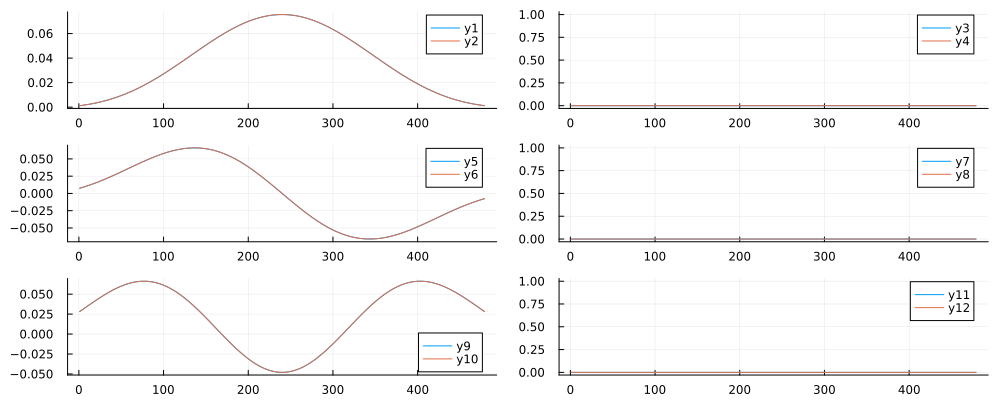

In [10]:
p = plot(layout=(3, 2), size=(1000, 400))  # Define a combined layout
for i in 1:3
    plot!(p,real(evecs[i,:]), layout=(3, 2),subplot=1+(i-1)*2)
    plot!(p,real(py_windows2[i,:]),subplot=1+(i-1)*2)
    plot!(p,imag(evecs[i,:]),subplot=2+(i-1)*2)
    plot!(p,imag(py_windows2[i,:]),subplot=2+(i-1)*2)
end
display(p)

In [ ]:
tfr = Array{ComplexF64,5}(undef, n_epochs, n_channels, n_taps, n_freqs, n_times)


In [11]:
function tfr_estimate_size(n_epochs, n_channels, n_taps, n_freqs, n_times)
    element_size = 16 # bytes for ComplexF64
    total_elements = n_epochs * n_channels * n_taps * n_freqs * n_times
    total_bytes = total_elements * element_size
    total_gb = total_bytes / (1024^3) # Convert bytes to GB
    return total_gb
end

function weights_estimate_size(n_taps, n_freqs, n_times)
    element_size = 8 # bytes for Float64
    total_elements = n_taps * n_freqs * n_times
    total_bytes = total_elements * element_size
    total_gb = total_bytes / (1024^3) # Convert bytes to GB
    return total_gb
end

function Ws_estimate_size(n_taps, freqs, sfreq, n_cycles)
    element_size = 16 # bytes for ComplexF64
    total_elements = 0
    for k = 1:n_freqs
        f = freqs[k]
        t_win = n_cycles / f
        len_t = Int(ceil(t_win * sfreq))
        total_elements += n_taps * len_t
    end
    total_bytes = total_elements * element_size
    total_gb = total_bytes / (1024^3) # Convert bytes to GB
    return total_gb
end

function fft_estimate_size(a, b, c)
    element_size = 16 # bytes for ComplexF64
    total_elements = a * b * c
    total_bytes = total_elements * element_size
    total_gb = total_bytes / (1024^3) # Convert bytes to GB
    return total_gb
end

function psd_estimate_size(n_epochs, n_channels, n_freqs, n_times)
    element_size = 8 # bytes for Float64
    total_elements = n_epochs * n_channels * n_freqs * n_times
    total_bytes = total_elements * element_size
    total_gb = total_bytes / (1024^3) # Convert bytes to GB
    return total_gb
end

function coh_estimate_size(n_epochs, n_channels, n_freqs)
    element_size = 8 # bytes for Float64
    total_elements = n_epochs * n_channels * n_channels * n_freqs
    total_bytes = total_elements * element_size
    total_gb = total_bytes / (1024^3) # Convert bytes to GB
    return total_gb
end





function next_fast_len(target::Int)::Int
    """
    Find the next fast size of input data to `fft`, for zero-padding, etc.

    Returns the next composite of the prime factors 2, 3, and 5 which is
    greater than or equal to `target`. (These are also known as 5-smooth
    numbers, regular numbers, or Hamming numbers.)

    Parameters
    ----------
    target : Int
        Length to start searching from. Must be a positive integer.

    Returns
    -------
    out : Int
        The first 5-smooth number greater than or equal to `target`.
    """
    # Precomputed Hamming numbers (5-smooth numbers) for quick lookup
    hams = [
        8, 9, 10, 12, 15, 16, 18, 20, 24, 25, 27, 30, 32, 36, 40, 45, 48, 50,
        54, 60, 64, 72, 75, 80, 81, 90, 96, 100, 108, 120, 125, 128, 135, 144,
        150, 160, 162, 180, 192, 200, 216, 225, 240, 243, 250, 256, 270, 288,
        300, 320, 324, 360, 375, 384, 400, 405, 432, 450, 480, 486, 500, 512,
        540, 576, 600, 625, 640, 648, 675, 720, 729, 750, 768, 800, 810, 864,
        900, 960, 972, 1000, 1024, 1080, 1125, 1152, 1200, 1215, 1250, 1280,
        1296, 1350, 1440, 1458, 1500, 1536, 1600, 1620, 1728, 1800, 1875, 1920,
        1944, 2000, 2025, 2048, 2160, 2187, 2250, 2304, 2400, 2430, 2500, 2560,
        2592, 2700, 2880, 2916, 3000, 3072, 3125, 3200, 3240, 3375, 3456, 3600,
        3645, 3750, 3840, 3888, 4000, 4050, 4096, 4320, 4374, 4500, 4608, 4800,
        4860, 5000, 5120, 5184, 5400, 5625, 5760, 5832, 6000, 6075, 6144, 6250,
        6400, 6480, 6561, 6750, 6912, 7200, 7290, 7500, 7680, 7776, 8000, 8100,
        8192, 8640, 8748, 9000, 9216, 9375, 9600, 9720, 10000
    ]

    if target <= 6
        return target
    end

    # Check if target is already a power of 2
    if (target & (target - 1)) == 0
        return target
    end

    # Quick lookup for small sizes
    if target <= hams[end]
        idx = searchsortedfirst(hams, target)
        return hams[idx]
    end

    # Function to compute the bit length of an integer
    bit_length(x::Int) = x <= 0 ? 0 : floor(Int, log2(x)) + 1

    match = typemax(Int)  # Initialize with maximum possible integer
    p5 = 1
    while p5 < target
        p35 = p5
        while p35 < target
            # Ceiling integer division
            quotient = cld(target, p35)
            p2 = 2^bit_length(quotient - 1)
            N = p2 * p35
            if N == target
                return N
            elseif N < match
                match = N
            end
            p35 *= 3
            if p35 == target
                return p35
            end
        end
        if p35 < match
            match = p35
        end
        p5 *= 5
        if p5 == target
            return p5
        end
    end
    if p5 < match
        match = p5
    end
    return match
end

next_fast_len (generic function with 1 method)

In [14]:
data = rand(606,97,1024)
n_taps = 3
n_cycles = 7
freqs = collect(14:1023)
sfreq = 2048

max_gb = 0
reserve_gb = 16
if max_gb == 0
    max_gb = Sys.total_memory() / (1024^3) - reserve_gb # Leave 32 GB for other stuff
end
current_mem = Sys.free_memory() / (1024^3)

if current_mem <= max_gb
    println("Current free memory: $current_mem GB")
    println("Desired max: $max_gb GB")
    println("System total memory: $(Sys.total_memory() / (1024^3)) GB")
    error("Memory available is less than desired max")
end

n_epoch_org, n_channels, n_times = size(data)
n_freqs = length(freqs)
t_win = n_cycles / minimum(freqs)
max_len = Int(ceil(t_win * sfreq))
nfft = n_times + max_len - 1
nfft = next_fast_len(nfft)

data_size = Base.summarysize(data) / (1024^3)
weights = weights_estimate_size(n_taps, n_freqs, n_times)
Ws = Ws_estimate_size(n_taps, freqs, sfreq, n_cycles)
fft_Ws = fft_estimate_size(n_taps, n_freqs, nfft)
fft_X = fft_estimate_size(n_epoch_org, n_channels, nfft)
coherence_mean = coh_estimate_size(n_epoch_org, n_channels, 1)

0.04248212277889252

In [ ]:
tfr_estimate_size(39, n_channels, n_taps, n_freqs, n_times)

174.90371704101562

: 

In [ ]:


current_mem = Sys.free_memory() / (1024^3)

static_total = data_size + weights + Ws + coherence_mean + fft_Ws + fft_X

if static_total >= max_gb || static_total >= current_mem
    println("Static memory exceeds memory!")
    println("---------------------------------")
    println("Current free memory: $current_mem GB")
    println("---------------------------------")
    println("Data: $(data_size) GB")
    println("Weights: $weights GB")
    println("Ws: $Ws GB")
    println("Coherence Mean: $coherence_mean GB")
    println("---------------------------------")
    println("Total: $static_total GB")
    println("Exceeds maximum memory limit of $max_gb GB or current free memory")
    error("Memory limit exceeded")
end

n_epochs = copy(n_epoch_org)
tfr_size = tfr_estimate_size(n_epochs, n_channels, n_taps, n_freqs, n_times)
psd_per_epoch = psd_estimate_size(n_epochs, n_channels, n_freqs, n_times)
coherence = coh_estimate_size(n_epoch_org, n_channels, n_freqs)
coherence_mean_small = 0

total_size = static_total  + tfr_size + psd_per_epoch + coherence + coherence_mean_small
current_mem = Sys.free_memory() / (1024^3)



Data: 0.4484711214900017 GB
Weights: 0.0231170654296875 GB
Ws: 0.0027958452701568604 GB
FFT Ws: 0.09246826171875 GB
FFT X: 0.1302490234375 GB
TFR: 2717.7346801757812 GB
PSD: 452.9557800292969 GB
Coherence: 42.90694400668144 GB
Coherence Mean (small): 0 GB
Coherence Mean: 0.04248212277889252 GB
---------------------------------
Total: 3214.3369876518846 GB
Desired max: 235.53413772583008 GB
Current free memory: 236.45062255859375 GB
System total memory: 251.53413772583008 GB


In [34]:
system_mem = Sys.total_memory() / (1024^3)

251.53413772583008

In [ ]:
@warn "Current free memory: $current_mem GB\nDesired max: $max_gb GB\nSystem total memory: $(system_mem) GB\nMemory available is less than desired max!\nUsing available memory!"

┌ Warning: Current free memory: 236.45062255859375 GB
│ Desired max: 235.53413772583008 GB
│ System total memory: 251.53413772583008 GB
│ Memory available is less than desired max!
│ Using available memory
└ @ Main In[35]:1


In [30]:
dynamic_total = tfr_size + psd_per_epoch + coherence + coherence_mean_small
while dynamic_total + static_total >= max_gb && n_epochs > 0
    n_epochs -= 1
    tfr_size = tfr_estimate_size(n_epochs, n_channels, n_taps, n_freqs, n_times)
    psd_per_epoch = psd_estimate_size(n_epochs, n_channels, n_freqs, n_times)
    coherence = coh_estimate_size(n_epochs, n_channels, n_freqs)
    coherence_mean_small = coh_estimate_size(n_epochs, n_channels, 1)
    dynamic_total = tfr_size + psd_per_epoch + coherence + coherence_mean_small
end

In [32]:

if n_epochs < 1
    println("Cannot compute even one epoch with current memory!")
    println("---------------------------------")
    println("TFR: $tfr_size GB")
    println("FFT X: $fft_X GB")
    println("PSD: $psd_per_epoch GB")
    println("---------------------------------")
    println("Total: $dynamic_total GB")
    println("Exceeds maximum memory limit of $max_gb GB")
    error("Memory limit exceeded")
end


total_size = static_total  + tfr_size + psd_per_epoch + coherence + coherence_mean_small



234.07317254692316

In [6]:
using NPZ
using JLD2

# load array shaped (epoch,channel,channel,band) (1 in this case) for average
py_coh_org = npzread("/media/dan/Data/git/network_mining/connectivity/output/034_coh_winmsec-000500_overlap-000000.npy");
julia_coh = load("/media/dan/Data/git/network_mining/connectivity/julia_test/034_coherence.jld2", "coherence_mean");


In [7]:
size(py_coh_org)

(606, 97, 97, 1)

In [8]:
size(julia_coh)

(5, 97, 97, 1)

In [16]:
isapprox(py_coh_org[5,:,:,1],julia_coh[5,:,:,1], atol=1e-13)

true